In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Step 1: Preprocessing
def preprocess_data(data, label_column='label'):
    """
    Preprocess the dataset by aggregating numeric features by the domain name label,
    normalizing, and returning the aggregated data and labels.
    """
    numeric_columns = data.select_dtypes(include=['number']).columns

    # Aggregate numeric features by label
    aggregated_data = data.groupby(label_column)[numeric_columns].mean().reset_index()

    # Check for NaN values and handle them
    aggregated_data = aggregated_data.fillna(0)

    # Separate labels and numerical data
    labels = aggregated_data[label_column]
    numerical_data = aggregated_data.drop(columns=[label_column])

    # Normalize the data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(numerical_data)

    return normalized_data, labels

# Load the dataset
training_data_path = './https_training.csv'
training_data = pd.read_csv(training_data_path)

# Preprocess data
normalized_data, domain_labels = preprocess_data(training_data)

# Apply PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)


Number of numeric features before PCA: 121
Number of PCA components: 13
Feature contributions to principal components:
       _c_ack_cnt  _c_ack_cnt_p  _c_appdataB  _c_appdataT  _c_bytes_all  \
PC1     0.163232      0.162718    -0.030668    -0.015509      0.066669   
PC2     0.034748     -0.005144     0.019513    -0.047664      0.207930   
PC3     0.037362      0.054417     0.099938     0.045347     -0.094205   
PC4    -0.040906     -0.034241     0.219678     0.087330     -0.055769   
PC5    -0.027066     -0.030450    -0.105639     0.003678      0.030601   
PC6     0.030536      0.029961     0.111537     0.017224      0.019031   
PC7    -0.022965     -0.019244     0.056304     0.007998      0.005854   
PC8    -0.000999     -0.000018     0.021260     0.351552     -0.000046   
PC9    -0.060856     -0.064350    -0.123903    -0.105481     -0.005712   
PC10    0.017659      0.029187    -0.036822     0.121847     -0.064844   
PC11    0.044655      0.056588     0.093546    -0.260847     -0.03

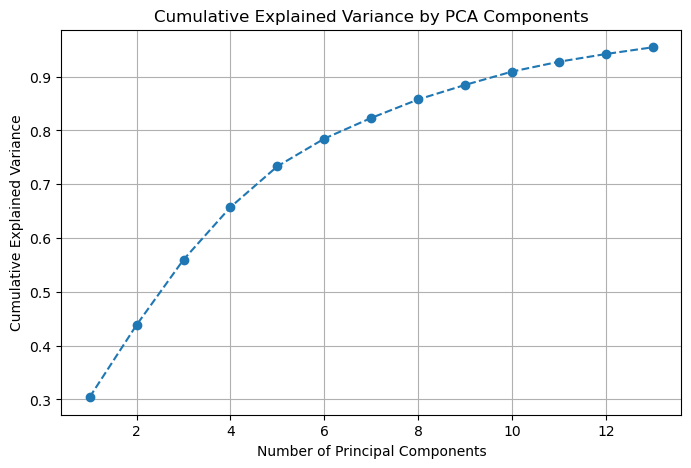

In [31]:
# Ensure proper numeric data selection before PCA
numerical_data = training_data.select_dtypes(include=['number'])
numerical_columns = numerical_data.columns
print("Number of numeric features before PCA:", len(numerical_columns))

# Apply PCA
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(normalized_data)

# Verify PCA components and column alignment
print("Number of PCA components:", pca.components_.shape[0])

# Feature importance mapping
loadings = pca.components_  # Principal components
try:
    feature_importance = pd.DataFrame(
        loadings,
        columns=numerical_columns,  # Use the original column names
        index=[f'PC{i+1}' for i in range(loadings.shape[0])]
    )
    print("Feature contributions to principal components:\n", feature_importance)
except ValueError as e:
    print("Error:", e)
    print("Check alignment between PCA components and feature names.")

# Plot Cumulative Explained Variance
explained_variance = pca.explained_variance_ratio_

# Create a cumulative sum of the variance explained
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


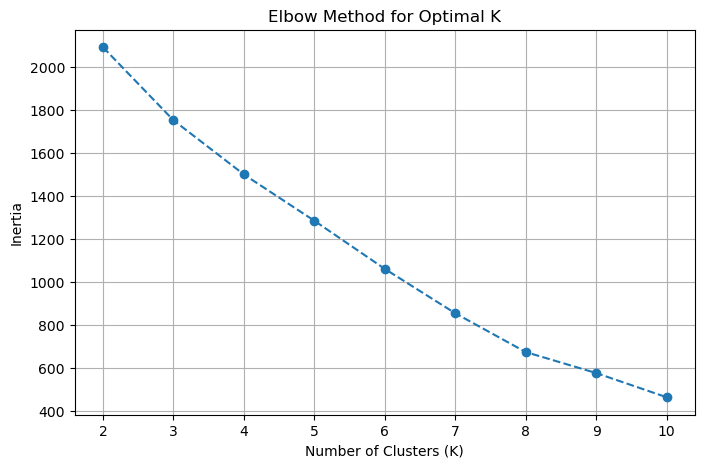

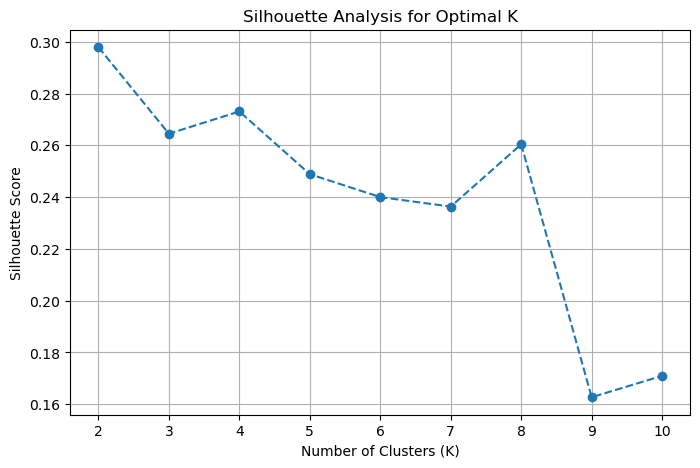

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 3: Determine Clusters Using K-Means
# Use the Elbow Method to determine optimal K
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_data, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Analysis for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

# Choose optimal K based on both methods (e.g., K=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(pca_data)


DBSCAN could not find valid clusters.
                    Metric   K-Means DBSCAN
0         Silhouette Score  0.273109    N/A
1  Calinski-Harabasz Index  6.242957    N/A
2     Davies-Bouldin Score  0.952001    N/A


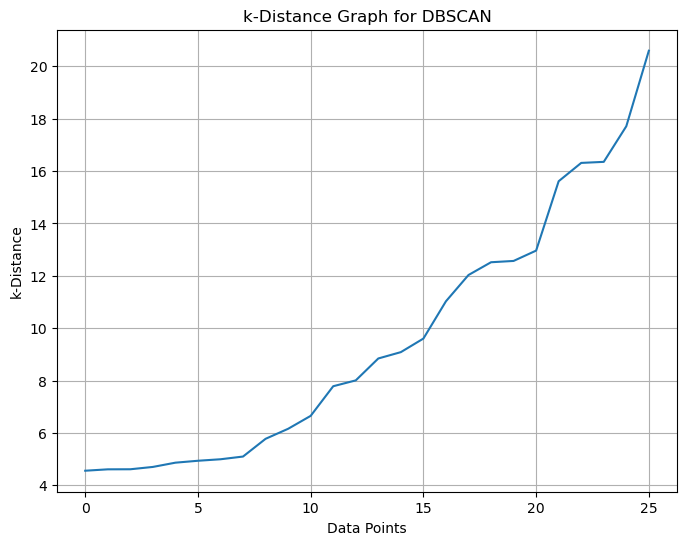

In [33]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN

# Step 4: DBSCAN Clustering
# Expanded parameter search
eps_values = [0.1, 0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 10, 15, 20]

best_dbscan_params = None
best_dbscan_score = -1
dbscan_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(pca_data)

        # Ignore noise (-1) when evaluating clusters
        if len(set(labels)) > 1 and -1 in labels:
            valid_labels = labels[labels != -1]
            silhouette = silhouette_score(pca_data[labels != -1], valid_labels)
            if silhouette > best_dbscan_score:
                best_dbscan_score = silhouette
                best_dbscan_params = (eps, min_samples)
                dbscan_labels = labels

# Output best DBSCAN parameters
if best_dbscan_params:
    print(f"Best DBSCAN Parameters: eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]}")
else:
    print("DBSCAN could not find valid clusters.")
    dbscan_silhouette = dbscan_calinski = dbscan_davies = None

# Step 5: Evaluate Clustering Metrics
def evaluate_clustering(data, labels):
    if len(set(labels)) > 1:
        silhouette = silhouette_score(data, labels)
        calinski = calinski_harabasz_score(data, labels)
        davies = davies_bouldin_score(data, labels)
        return silhouette, calinski, davies
    return None, None, None

# Evaluate K-Means
kmeans_silhouette, kmeans_calinski, kmeans_davies = evaluate_clustering(pca_data, kmeans_labels)

# Evaluate DBSCAN
if dbscan_labels is not None:
    dbscan_silhouette, dbscan_calinski, dbscan_davies = evaluate_clustering(pca_data, dbscan_labels)

# Summarize Clustering Metrics
metrics = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Score'],
    'K-Means': [kmeans_silhouette, kmeans_calinski, kmeans_davies],
    'DBSCAN': [dbscan_silhouette if dbscan_silhouette else "N/A",
               dbscan_calinski if dbscan_calinski else "N/A",
               dbscan_davies if dbscan_davies else "N/A"]
})
print(metrics)

from sklearn.neighbors import NearestNeighbors

k = 5  # Same as min_samples
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(pca_data)
distances, indices = nearest_neighbors.kneighbors(pca_data)
distances = np.sort(distances[:, k - 1])  # k-th nearest distances

plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('k-Distance Graph for DBSCAN')
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.grid()
plt.show()


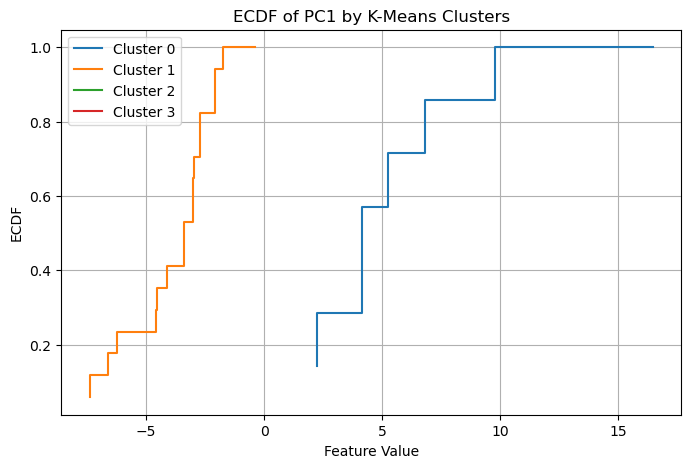

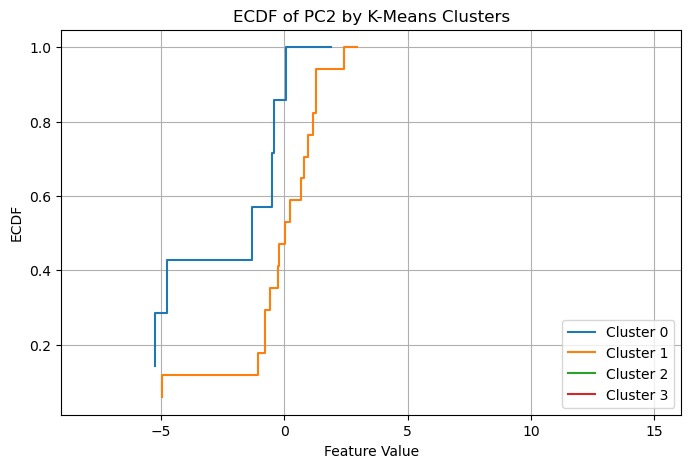


K-Means Cluster Sizes:
Cluster
0     7
1    17
2     1
3     1
dtype: int64

The largest K-Means cluster is Cluster 1 with 17 domain names.
The smallest K-Means cluster is Cluster 2 with 1 domain names.

Cluster 0 Example Domains:
['_other' 'giphy.com' 'redd.it' 'reddit.com' 'scdn.co']

Cluster 1 Example Domains:
['adnxs.com' 'ads-twitter.com' 'chartbeat.com' 'contextweb.com'
 'disqus.com']

Cluster 2 Example Domains:
['ftcdn.net']

Cluster 3 Example Domains:
['vimeocdn.com']

DBSCAN did not produce valid clusters.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 6: ECDF Analysis
def plot_ecdf(data, cluster_labels, title):
    """
    Plot ECDF for clusters.
    """
    unique_clusters = np.unique(cluster_labels)
    plt.figure(figsize=(8, 5))
    for cluster in unique_clusters:
        cluster_data = data[cluster_labels == cluster]
        sorted_data = np.sort(cluster_data)
        ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        plt.step(sorted_data, ecdf, label=f'Cluster {cluster}')
    plt.title(title)
    plt.xlabel('Feature Value')
    plt.ylabel('ECDF')
    plt.legend()
    plt.grid()
    plt.show()

# Plot ECDF for multiple PCA components by K-Means clusters
for i in range(2):  # Analyze the first two PCA components
    plot_ecdf(pca_data[:, i], kmeans_labels, f'ECDF of PC{i+1} by K-Means Clusters')

# Plot ECDF for multiple PCA components by DBSCAN clusters
if dbscan_labels is not None and len(set(dbscan_labels)) > 1:
    for i in range(2):  # Analyze the first two PCA components
        plot_ecdf(pca_data[:, i], dbscan_labels, f'ECDF of PC{i+1} by DBSCAN Clusters')

# Step 7:  Analysis of Domain Families
# Analyze K-Means cluster sizes
kmeans_clusters = pd.DataFrame({'Domain': domain_labels, 'Cluster': kmeans_labels})
kmeans_cluster_sizes = kmeans_clusters.groupby('Cluster').size()

print("\nK-Means Cluster Sizes:")
print(kmeans_cluster_sizes)

# Add interpretation of cluster sizes
largest_cluster = kmeans_cluster_sizes.idxmax()
smallest_cluster = kmeans_cluster_sizes.idxmin()
print(f"\nThe largest K-Means cluster is Cluster {largest_cluster} with {kmeans_cluster_sizes[largest_cluster]} domain names.")
print(f"The smallest K-Means cluster is Cluster {smallest_cluster} with {kmeans_cluster_sizes[smallest_cluster]} domain names.")

# Example domain names for each K-Means cluster
for cluster in kmeans_clusters['Cluster'].unique():
    cluster_domains = kmeans_clusters[kmeans_clusters['Cluster'] == cluster]['Domain'].head(5)
    print(f"\nCluster {cluster} Example Domains:")
    print(cluster_domains.values)

# Analyze DBSCAN cluster sizes if valid
if dbscan_labels is not None and len(set(dbscan_labels)) > 1:
    dbscan_clusters = pd.DataFrame({'Domain': domain_labels, 'Cluster': dbscan_labels})
    dbscan_cluster_sizes = dbscan_clusters.groupby('Cluster').size()

    print("\nDBSCAN Cluster Sizes:")
    print(dbscan_cluster_sizes)

    # Add noise ratio analysis
    noise_ratio = (dbscan_labels == -1).sum() / len(dbscan_labels)
    print(f"\nDBSCAN Noise Ratio: {noise_ratio:.2%}")

    # Example domain names for each DBSCAN cluster
    for cluster in dbscan_clusters['Cluster'].unique():
        if cluster != -1:  # Exclude noise
            cluster_domains = dbscan_clusters[dbscan_clusters['Cluster'] == cluster]['Domain'].head(5)
            print(f"\nCluster {cluster} Example Domains (DBSCAN):")
            print(cluster_domains.values)
else:
    print("\nDBSCAN did not produce valid clusters.")


In [35]:
# Step 1: Extract domain names and cluster labels
kmeans_clusters = pd.DataFrame({'Domain': domain_labels, 'Cluster': kmeans_labels})

# Step 2: Extract example domains from each cluster
print("\nExample Domain Names for K-Means Clusters:")
for cluster in kmeans_clusters['Cluster'].unique():
    cluster_domains = kmeans_clusters[kmeans_clusters['Cluster'] == cluster]['Domain'].head(10)  # Top 10 examples
    print(f"\nCluster {cluster} Example Domains:")
    print(cluster_domains.values)

# If DBSCAN produced valid clusters
if dbscan_labels is not None and len(set(dbscan_labels)) > 1:
    dbscan_clusters = pd.DataFrame({'Domain': domain_labels, 'Cluster': dbscan_labels})

    print("\nExample Domain Names for DBSCAN Clusters:")
    for cluster in dbscan_clusters['Cluster'].unique():
        if cluster != -1:  # Exclude noise
            cluster_domains = dbscan_clusters[dbscan_clusters['Cluster'] == cluster]['Domain'].head(10)  # Top 10 examples
            print(f"\nCluster {cluster} Example Domains (DBSCAN):")
            print(cluster_domains.values)
else:
    print("\nDBSCAN did not produce valid clusters.")



Example Domain Names for K-Means Clusters:

Cluster 0 Example Domains:
['_other' 'giphy.com' 'redd.it' 'reddit.com' 'scdn.co' 'slack-edge.com'
 'twimg.com']

Cluster 1 Example Domains:
['adnxs.com' 'ads-twitter.com' 'chartbeat.com' 'contextweb.com'
 'disqus.com' 'everesttech.net' 'fastly-insights.com' 'fastly.net'
 'githubusercontent.com' 'krxd.net']

Cluster 2 Example Domains:
['ftcdn.net']

Cluster 3 Example Domains:
['vimeocdn.com']

DBSCAN did not produce valid clusters.
